# Functions

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split

import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split, LeaveOneOut

import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Code

In [14]:


def get_val_results():
   
    main_data = pd.read_excel('Validation_Interpolate_Median.xlsx')

  
    results_dir = "./Results_Validation_Median"
    test_data_dir = "./ExcelsPrecision_Median"


    def format_parameters(param):
        return param.replace('_', '', 1)

    def format_frame(frame):
        frame_num = int(frame.split('_')[-1])
        return f"result_frame_{frame_num:06d}",frame_num


    filtered_data = main_data[main_data['Result'] == 1]


    combined_data = []

 
    for _, row in filtered_data.iterrows():
        video = row['Video']
        raw_frame = row['Frame']
        frame, frame_num = format_frame(raw_frame)
        params = format_parameters(row['Parameters'])

    
        image_path = os.path.join(results_dir, video, f"{video}_Results_bw{params}", f"{frame}.png")
        test_data_path = os.path.join(test_data_dir, f"{video}_{params}_comapprox_post_processed_median.xlsx")

 
        if os.path.exists(test_data_path):
            test_data = pd.read_excel(test_data_path, index_col=0)  
            if frame_num in test_data.index:  
                test_row = test_data.loc[frame_num]
                combined_data.append({
                    'Image Path': image_path,
                    'Video': video,
                    'Frame': frame,
                    'Parameters': params,
                    'center_y(ccol)': test_row['center_y(ccol)'],
                    'center_x(crow)': test_row['center_x(crow)'],
                    'circle_radius': test_row['circle_radius']
                })
            else:
                print(f"Warning: Frame {frame_num} not found in {test_data_path}")
        else:
            print(f"Warning: Test data file not found for {test_data_path}")

    # Create DataFrame from combined data
    result_df = pd.DataFrame(combined_data)

    # Save to Excel
    output_path = "combined_results.xlsx"
    result_df.to_excel(output_path, index=False)
    print(f"Combined results saved to {output_path}")


In [ ]:

def build_autoencoder(input_shape=(256, 256, 1)):
   
    input_img = Input(shape=input_shape, name='input_image')


    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Flatten(name='encoded_features')(x)


    radius_pred = Dense(1, activation='linear', name='radius_output')(encoded)
    ccol_pred = Dense(1, activation='linear', name='ccol_output')(encoded)
    crow_pred = Dense(1, activation='linear', name='crow_output')(encoded)


    x = Dense(1024, activation='relu')(encoded)
    x = Reshape((4, 4, 64))(x)


    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 8x8
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 16x16
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 64x64
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 128x128
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 256x256
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='image_output')(x)

    
    autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred,ccol_pred,crow_pred], name='autoencoder')




  
    # autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred], name='autoencoder')
    return autoencoder


def train_autoencoder(autoencoder, x_train, radii_train, x_val, radii_val,ccol_train,crow_train,ccol_val,crow_val, epochs=50, batch_size=32):
    autoencoder.compile(
        optimizer='adam',
        loss={'image_output': 'mse', 'radius_output': 'mse', 'ccol_output': 'mse', 'crow_output': 'mse'}
    )

   
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

   
    history = autoencoder.fit(
        x_train,
        {'image_output': x_train, 'radius_output': radii_train,'ccol_output':ccol_train,'crow_output':crow_train},
        validation_data=(x_val, {'image_output': x_val, 'radius_output': radii_val, 'ccol_output': ccol_val, 'crow_output': crow_val}),
        epochs=50,
        batch_size=32
    )


    autoencoder.summary()

    return history


In [2]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')


In [ ]:
# def build_autoencoder(input_shape=(256, 256, 1)):
   
#     input_img = Input(shape=input_shape, name='input_image')


#     x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
#     x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
#     encoded = Flatten(name='encoded_features')(x)
#     # Use Reshape instead of Flatten
#     # encoded= Reshape((4, 4, 64), name='encoded_features')(x)



#     radius_pred = Dense(1, activation='linear', name='radius_output')(encoded)
#     ccol_pred = Dense(1, activation='linear', name='ccol_output')(encoded)
#     crow_pred = Dense(1, activation='linear', name='crow_output')(encoded)


#     x = Dense(256, activation='relu')(encoded)
#     x = Reshape((4, 4, 16))(x)  


#     x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 128x128
#     x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # 256x256
#     decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='image_output')(x)


    
#     autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred,ccol_pred,crow_pred], name='autoencoder')




  
#     # autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred], name='autoencoder')
#     return autoencoder
# shit results

In [4]:
def build_autoencoder(input_shape=(256, 256, 1)):
    input_img = Input(shape=input_shape, name='input_image')

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)  # Down to 128x128
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)  # Down to 64x64
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Flatten features for predictions
    encoded = Flatten(name='encoded_features')(x)

    # Predict key features
    radius_pred = Dense(1, activation='linear', name='radius_output')(encoded)
    ccol_pred = Dense(1, activation='linear', name='ccol_output')(encoded)
    crow_pred = Dense(1, activation='linear', name='crow_output')(encoded)

    # Efficient Decoder with Conv2DTranspose
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(x)  
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu')(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='image_output')(x)

    # Define the model
    autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred, ccol_pred, crow_pred], name='autoencoder')

    return autoencoder


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
df = pd.read_excel('combined_results.xlsx')

image_paths = df['Image Path'].tolist()  
img_height, img_width = 256, 256  
images = []

for path in image_paths:
  
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  
    images.append(img_array)


radii = df['circle_radius'].values   
ccol = df['center_y(ccol)'].values
crow = df['center_x(crow)'].values

images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)
ccol = ccol.reshape(-1, 1)
crow = crow.reshape(-1, 1)

loo=LeaveOneOut()

for i, (train_index, test_index) in enumerate(loo.split(df)):
    # print(f"Fold {i}:")

    # print(f"  Train: index={train_index}")

    # print(f"  Test:  index={test_index}")
    # images_train = [images[j] for j in train_index]
    images_train = images[train_index]
    images_test=images[test_index]

    # radii_train = [radii[j] for j in train_index]
    radii_train = radii[train_index]
    radii_test=radii[test_index]
                                 
    # ccol_train = [ccol[j] for j in train_index]
    ccol_train = ccol[train_index]
    ccol_test=ccol[test_index]
                                 
    # crow_train = [crow[j] for j in train_index]
    crow_train = crow[train_index]
    crow_test=crow[test_index]
    # print(image_paths_train)

    autoencoder = build_autoencoder(input_shape=(img_height, img_width, 1))

    autoencoder.compile(
        optimizer='adam',
        loss={
            'image_output': 'mse',
            'radius_output': 'mse',
            'ccol_output': 'mse',
            'crow_output': 'mse'
        }
    )

    # print(images_test.shape)  # Should be (num_samples, 256, 256, 1)
    # print(radii_train.shape)   # Should be (num_samples, 1)
    # print(ccol_train.shape)    # Should be (num_samples, 1)
    # print(crow_train.shape)    # Should be (num_samples, 1)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = autoencoder.fit(
        images_train,
        {
            'image_output': images_train, 
            'radius_output': radii_train,
            'ccol_output':ccol_train,
            'crow_output':crow_train
        },
        validation_data=(images_test,{
            'image_output': images_test,
            'radius_output': radii_test,
            'ccol_output': ccol_test,
            'crow_output': crow_test
        }),
        validation_split=0.1,
        epochs=50,
        # batch_size=32,
        batch_size=1,
        callbacks=[early_stopping],
        verbose=1
    )

    # Save the model for the current fold
    model_path = os.path.join('models', f'autoencoder_fold_{i+1}.h5')
    autoencoder.save(model_path)
    print(f"Saved model to {model_path}")

Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - ccol_output_loss: 29.4556 - crow_output_loss: 170.9219 - image_output_loss: 20424.4668 - loss: 21933.5078 - radius_output_loss: 1308.6598 - val_ccol_output_loss: 0.0747 - val_crow_output_loss: 2.0391 - val_image_output_loss: 20019.3496 - val_loss: 20035.8848 - val_radius_output_loss: 14.4222
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - ccol_output_loss: 0.1842 - crow_output_loss: 10.3597 - image_output_loss: 20250.4238 - loss: 20313.1328 - radius_output_loss: 52.1674 - val_ccol_output_loss: 0.1145 - val_crow_output_loss: 4.1299 - val_image_output_loss: 20019.3477 - val_loss: 20029.2031 - val_radius_output_loss: 5.6096
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - ccol_output_loss: 0.2403 - crow_output_loss: 7.6662 - image_output_loss: 20360.2246 - loss: 20391.4746 - radius_output_loss: 23.3509 - val_ccol_output_loss: 0.3222 - val_crow_output_loss: 3.5913 - val_image_output_loss: 20019.3477 - val_loss: 20059.05

In [ ]:
autoencoder,.summary()

In [19]:
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 128, 128,  │        160 │ input_image[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 64, 64,    │      4,640 │ conv2d_58[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoded_features    │ (None, 131072)    │          0 │ conv2d_59[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │ 33,554,688 │ encoded_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 4, 4, 16)  │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 8, 8, 64)  │      9,280 │ reshape_8[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 16, 16,    │     18,464 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 32, 32,    │      4,624 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 64, 64, 8) │      1,160 │ conv2d_transpose… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 128, 128,  │        292 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_11 │ (None, 256, 256,  │         37 │ conv2d_transpose… │
│ (Conv2DTranspose)   │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ radius_output       │ (None, 1)         │    131,073 │ encoded_features… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ccol_output (Dense) │ (None, 1)         │    131,073 │ encoded_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ crow_output (Dense) │ (None, 1)         │    131,073 │ encoded_features… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,986,564 (129.65 MB)

 Trainable params: 33,986,564 (129.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:



df = pd.read_excel('combined_results.xlsx')


image_paths = df['Image Path'].tolist()  
radii = df['circle_radius'].values   
ccol = df['center_y(ccol)'].values
crow = df['center_x(crow)'].values


img_height, img_width = 256, 256  
images = []

for path in image_paths:
  
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  
    images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)
ccol = ccol.reshape(-1, 1)
crow = crow.reshape(-1, 1)


x_train, x_val, radii_train, radii_val = train_test_split(
    images, radii, test_size=0.2, random_state=42
)


autoencoder = build_autoencoder(input_shape=(img_height, img_width, 1))  # Function from earlier code
history = train_autoencoder(autoencoder, x_train, radii_train, x_val, radii_val, epochs=50, batch_size=32)


autoencoder.save('diffraction_autoencoder_center.h5')


test_images = x_val[:10]  
reconstructed_images, predicted_radii = autoencoder.predict(test_images)


print("Predicted Radii:", predicted_radii.flatten())


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - image_output_loss: 0.1239 - loss: 703.8712 - radius_output_loss: 694.4341 - val_image_output_loss: 0.0320 - val_loss: 17.3975 - val_radius_output_loss: 18.7477
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - image_output_loss: 0.0310 - loss: 89.3917 - radius_output_loss: 88.2035 - val_image_output_loss: 0.0259 - val_loss: 10.7619 - val_radius_output_loss: 11.5548
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - image_output_loss: 0.0262 - loss: 30.7752 - radius_output_loss: 30.7307 - val_image_output_loss: 0.0248 - val_loss: 17.0642 - val_radius_output_loss: 15.6670
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - image_output_loss: 0.0248 - loss: 17.5901 - radius_output_loss: 17.7727 - val_image_output_loss: 0.0241 - val_loss: 24.5272 - val_radius_output_loss: 25.9875
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - image_output_loss: 0.0247 - loss: 16.4167 - radius_output_loss: 16.5270 - val_image_output_loss: 0.0234 - val_loss: 

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoded_features    │ (None, 262144)    │          0 │ max_pooling2d_1[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │ 268,436,4… │ encoded_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 4, 64)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 64)  │     36,928 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 8, 8, 64)  │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 16, 16,    │          0 │ conv2d_3[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     18,464 │ up_sampling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      4,624 │ up_sampling2d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64, 8) │      1,160 │ up_sampling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 128, 128,  │          0 │ conv2d_6[0][0]    │
│ (UpSampling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 806,447,624 (3.00 GB)

 Trainable params: 268,815,874 (1.00 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 537,631,750 (2.00 GB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Radii: [38.81435  37.091206 36.410633 37.931423 38.79761  37.782333 39.020638
 36.717205 34.80306  33.926716]


In [6]:
print(radii_val[:10])

[[38.993984 ]
 [36.2506446]
 [36.5000622]
 [38.0001896]
 [38.9989406]
 [37.745165 ]
 [39.005028 ]
 [36.9944262]
 [35.2398808]
 [33.995009 ]]


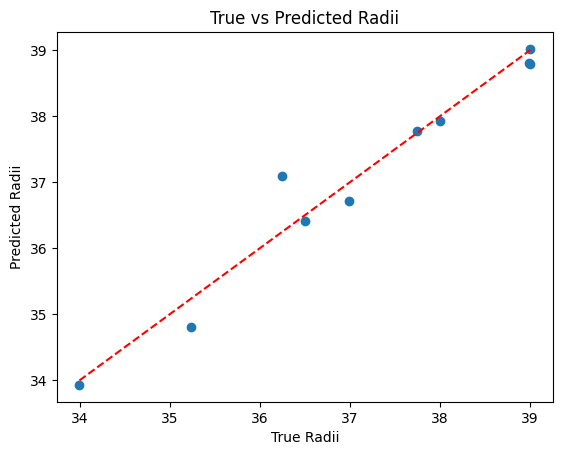

In [ ]:


# Plot true vs predicted radii
plt.scatter(radii_val[:10], predicted_radii)
plt.plot([radii_val[:10].min(), radii_val[:10].max()], [radii_val[:10].min(), radii_val[:10].max()], color='r', linestyle='--')
plt.xlabel('True Radii')
plt.ylabel('Predicted Radii')
plt.title('True vs Predicted Radii')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 542ms/step


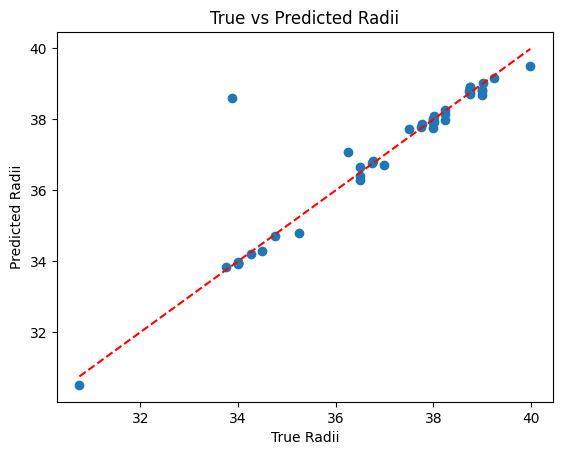

In [ ]:
df = pd.read_excel('combined_results.xlsx')


image_paths = df['Image Path'].tolist()  
radii = df['circle_radius'].values       

img_height, img_width = 256, 256 #FIXED DImensions
images = []

for path in image_paths:
   
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  
    images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)


x_train, x_val, radii_train, radii_val = train_test_split(
    images, radii, test_size=0.2, random_state=42
)

autoencoder = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
test_images = x_val
reconstructed_images, predicted_radii = autoencoder.predict(test_images)


plt.scatter(radii_val, predicted_radii)
plt.plot([radii_val.min(), radii_val.max()], [radii_val.min(), radii_val.max()], color='r', linestyle='--')
plt.xlabel('True Radii')
plt.ylabel('Predicted Radii')
plt.title('True vs Predicted Radii')
plt.show()


In [14]:
image_path='./Results_Validation/VideoLarge/cropped_object_1/frame_000000.png_object1.png'


img_height, img_width = 256, 256
img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
img_array = img_to_array(img) / 255.0  
images=[]
images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)

autoencoder = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
reconstructed_images, predicted_radii = autoencoder.predict(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


In [15]:
print(predicted_radii)

[[42.9282]]


In [11]:
import matplotlib.patches as patches

In [9]:
import cv2
from pathlib import Path

C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_17292\1157914790.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


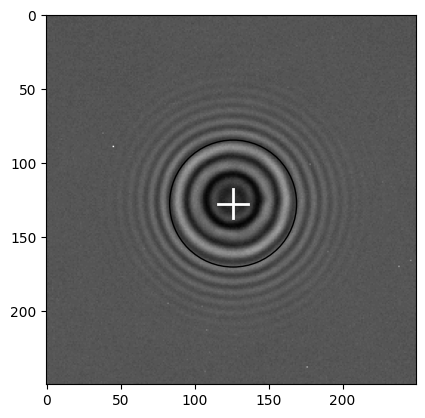

In [16]:
# image=reconstructed_images[0]
image = cv2.imread('./Results_Validation/VideoLarge/cropped_object_1/frame_000000.png_object1.png', cv2.IMREAD_GRAYSCALE)
ccol=125.9989183
crow=127.2544289
# plt.imshow(image2)
# plt.show()
circle_radius=predicted_radii[0]
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
circle_center=(ccol,crow)
circle = patches.Circle(circle_center, circle_radius, edgecolor='black', facecolor='none', linewidth=1)
ax.add_patch(circle)

cross_size = 10
ax.plot([circle_center[0] - cross_size, circle_center[0] + cross_size], 
            [circle_center[1], circle_center[1]], color='white', linewidth=2) 
ax.plot([circle_center[0], circle_center[0]], 
        [circle_center[1] - cross_size, circle_center[1] + cross_size], color='white', linewidth=2) 

fig.show()

